In [281]:
import tensorflow as tf
import unicodedata
import re
import numpy as np
import os
import io
import time
import collections
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Any

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM, SimpleRNN
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [176]:
from src.utils.file_helper import get_config

# globals
CONFIG_FILE = "config.toml"
# Load the configuration file
config = get_config(CONFIG_FILE)

Config file: /mnt/d/StFX/OneDrive - St. Francis Xavier University/CSCI 444/project/config.toml loaded!


In [177]:
# new dataset
data_dir = Path().resolve() / config["dir"]["data"]
# data_path = data_dir / "kan-eng" / "kan.txt"
data_path = data_dir / "en-kn-large"
engkan_data = []
count = 0
with open(data_path / "train.en", encoding="utf-8") as f1, open(data_path / "train.kn", encoding="utf-8") as f2:
    for idx, line in enumerate(f1):
        line = line.strip()
        kan_line = next(f2).strip()
        match = re.match("^[A-Za-z\s]*$", line) #  re.match("^[A-Za-z\s]*\,\.$", line)
        if (
            match
            and (len(line.split()) == 5)
            and all(word in words_to_pick for word in kan_line.split())
        ):
            count += 1
            engkan_data.append([line, kan_line])


In [178]:
count

379

In [179]:
# get most common 150 chars
english_words_counter = collections.Counter([word.lower() for sentence in engkan_data for word in sentence[1].split()])

# print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()

343 unique English words.
10 Most common words in the English dataset:
"ಸಾವು" "ಮತ್ತು" "ಕಥೆ" "ಜೀವನ" "ವಿರುದ್ಧ" "ಪ್ರತಿಭಟನೆ" "ಅಪಘಾತದಲ್ಲಿ" "ಬಿಜೆಪಿ" "ಇಲ್ಲಿದೆ" "ಬೈಕ್"



In [180]:
english_words_counter.most_common(5500)[-1]

('ಕೃಷಿ', 1)

In [181]:
words_to_pick = [word[0] for word in english_words_counter.most_common(500)]

In [182]:
import json
# words_to_pick = [word[0] for word in english_words_counter.most_common(200) + english_words_counter.most_common(500)[300:400]]
with open("words_to_pick.json", "w") as f:
    json.dump(words_to_pick, f)

In [183]:
# data_dir = Path().resolve() / config["dir"]["data"]
# data_path = data_dir / "kan-eng" / "kan.txt"
# data_path = data_dir / "hin-eng" / "hin.txt"

In [184]:
# engkan_data = []
# with open(data_path, encoding='utf-8') as f:
#     for line in f:
#         _tmp = line.split("\t")
#         engkan_data.append([_tmp[0].strip(), _tmp[1].strip()])

In [185]:
engkan_data = engkan_data[:10000]

In [186]:
def unicode_to_ascii(s: str) -> str:
    "Normalizes to NFD and remove accented characters"
    return "".join(c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn")


def preprocess_en(s: str) -> str:
    "Convert to ascii, substitue punctuations and append 'start' and 'end' tokens"
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([?.!|,¿])", r" \1 ", s)
    s = re.sub(r'[" "]+', " ", s)
    s = s.strip()
    s = "<start> " + s + " <end>"
    return s


def preprocess_kn(s):
    "Substitue punctuations and append 'start' and 'end' tokens"
    s = s.lower().strip()
    s = re.sub(r"([?.!|,¿])", r" \1 ", s)
    s = re.sub(r'[" "]+', " ", s)
    s = s.strip()
    s = "<start> " + s + " <end>"
    return s


def tokenize(lang: list) -> Any:
    "Tokenize the sentenses and padding to make all the same length"
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters="")
    tokenizer.fit_on_texts(lang)
    tensor = tokenizer.texts_to_sequences(lang)
    # Padding to the end of the sentence
    # ! hardcoded here maxlen = 19
    # tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=None, padding="post")
    return tensor, tokenizer


In [187]:
len(engkan_data)

379

In [188]:
eng_lang = [preprocess_en(w[0]) for w in engkan_data]
kan_lang = [preprocess_kn(w[1]) for w in engkan_data]

input_tensor, input_lang_tokenizer = tokenize(eng_lang)
target_tensor, target_lang_tokenizer = tokenize(kan_lang)

In [189]:
len(target_lang_tokenizer.word_index)

344

In [190]:
len([len(i) for i in target_tensor])

379

In [191]:
len([len(i) for i in target_tensor if len(i) <= 19])

379

In [192]:
_input_tensor, _target_tensor = [], []
for idx, val in enumerate(target_tensor):
    if len(val) <= 7:
        _input_tensor.append(input_tensor[idx])
        _target_tensor.append(target_tensor[idx])
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(_input_tensor, maxlen=None, padding="post")
target_tensor = tf.keras.preprocessing.sequence.pad_sequences(_target_tensor, maxlen=None, padding="post")

In [193]:
print(input_tensor.shape)
print(target_tensor.shape)

(355, 7)
(355, 7)


In [194]:
eng_lang[110], input_tensor[110]

('<start> as told by elva gjerde <end>',
 array([  1,  63,  10,   4, 120,  11,   2], dtype=int32))

In [195]:
kan_lang[110], target_tensor[110]

('<start> ಜೀವನ ಕಥೆ <end>',
 array([  1,  12, 206, 274,  47,   3,   2], dtype=int32))

In [196]:
max_targ_len, max_ip_len = target_tensor.shape[1], input_tensor.shape[1]
eng_vocab_size = len(input_lang_tokenizer.word_index)
kan_vocab_size = len(target_lang_tokenizer.word_index)

In [197]:
print("Max English sentence length:", max_ip_len)
print("Max Kannada sentence length:", max_targ_len)
print("English vocabulary size:", eng_vocab_size)
print("Kannada vocabulary size:", kan_vocab_size)

Max English sentence length: 7
Max Kannada sentence length: 7
English vocabulary size: 513
Kannada vocabulary size: 344


In [198]:
# # Retain words upto 13 words long only
# _input_tensor, _target_tensor = [], []
# for idx, arr in enumerate(input_tensor):
#     print(len(arr))
#     if len(arr) <= 12:
#         _input_tensor.append(arr)
#         _target_tensor.append(target_tensor[idx])
# # input_tensor = np.array(_input_tensor)
# # target_tensor = np.array(_target_tensor)

In [199]:
target_tensor.shape[-2]

355

In [200]:
target_tensor.shape

(355, 7)

In [201]:
# cross entropy needs labels in 3D
target_tensor = target_tensor.reshape(*target_tensor.shape, 1)

In [202]:
target_tensor.shape

(355, 7, 1)

In [203]:
input_tensor.shape

(355, 7)

In [204]:
input_tensor.shape

(355, 7)

In [205]:
tmp_y = target_tensor.reshape((target_tensor.shape[0], target_tensor.shape[1], 1))

In [206]:
tmp_x = input_tensor.reshape((*input_tensor.shape, 1))


In [207]:
tmp_x.shape[1:]

(7, 1)

In [208]:
# Hyperparameters
learning_rate = 0.005

model = Sequential()
model.add(GRU(64, input_shape=tmp_x.shape[1:], return_sequences=True))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(kan_vocab_size, activation="softmax"))

# Compile model
model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(learning_rate), metrics=["accuracy"])
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 7, 64)             12864     
_________________________________________________________________
dense_8 (Dense)              (None, 7, 1024)           66560     
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 1024)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 7, 344)            352600    
Total params: 432,024
Trainable params: 432,024
Non-trainable params: 0
_________________________________________________________________


In [209]:
target_tensor.shape

(355, 7, 1)

In [210]:
model.fit(tmp_x, target_tensor, batch_size=16, epochs=10, validation_split=0.2)

Epoch 1/10
18/18 [==============================] - 2s 28ms/step - loss: 4.4273 - accuracy: 0.3008 - val_loss: 3.7811 - val_accuracy: 0.3461
Epoch 2/10
18/18 [==============================] - 0s 11ms/step - loss: 3.4378 - accuracy: 0.3657 - val_loss: 3.3859 - val_accuracy: 0.4266
Epoch 3/10
18/18 [==============================] - 0s 12ms/step - loss: 3.1573 - accuracy: 0.4034 - val_loss: 3.2394 - val_accuracy: 0.4245
Epoch 4/10
18/18 [==============================] - 0s 10ms/step - loss: 2.9976 - accuracy: 0.4125 - val_loss: 3.1988 - val_accuracy: 0.4427
Epoch 5/10
18/18 [==============================] - 0s 10ms/step - loss: 2.8998 - accuracy: 0.4200 - val_loss: 3.2003 - val_accuracy: 0.4487
Epoch 6/10
18/18 [==============================] - 0s 9ms/step - loss: 2.8562 - accuracy: 0.4326 - val_loss: 3.1647 - val_accuracy: 0.4366
Epoch 7/10
18/18 [==============================] - 0s 9ms/step - loss: 2.7880 - accuracy: 0.4261 - val_loss: 3.1975 - val_accuracy: 0.4467
Epoch 8/10
18/1

In [211]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

In [212]:
logits_to_text(model.predict(tmp_x[:1])[0], target_lang_tokenizer)

'<start> ಇದು <end> <end> <PAD> <PAD> <PAD>'

In [213]:
eng_lang[:1]

['<start> economic development and social change <end>']

In [214]:
kan_lang[:1]

['<start> ಆರ್ಥಿಕ ಅಭಿವೃದ್ಧಿ ಮತ್ತು ಸಾಮಾಜಿಕ ಬದಲಾವಣೆ <end>']

## with embedding

In [218]:
tmp_x = input_tensor # .reshape(input_tensor.shape)

In [219]:
tmp_x.shape

(355, 7)

In [163]:
x=Embedding(eng_vocab_size, input_length=tmp_x.shape[1], input_shape=tmp_x.shape[1:])

In [255]:
# Hyperparameters
learning_rate = 0.001

model = Sequential()
model.add(Embedding(eng_vocab_size, 64, input_length=tmp_x.shape[1], input_shape=tmp_x.shape[1:]))
model.add(GRU(256, return_sequences=True))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(kan_vocab_size, activation="softmax"))

# Compile model
model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(learning_rate), metrics=["accuracy"])

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 7, 64)             32832     
_________________________________________________________________
gru_12 (GRU)                 (None, 7, 256)            247296    
_________________________________________________________________
dense_20 (Dense)             (None, 7, 1024)           263168    
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 1024)           0         
_________________________________________________________________
dense_21 (Dense)             (None, 7, 512)            524800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 512)            0         
_________________________________________________________________
dense_22 (Dense)             (None, 7, 344)          

In [256]:
target_tensor.shape

(355, 7, 1)

In [257]:
history = model.fit(tmp_x[2:, :], target_tensor[2:, :, :], batch_size=64, epochs=100, validation_split=0.2)

Epoch 1/100
5/5 [==============================] - 2s 120ms/step - loss: 5.8102 - accuracy: 0.2715 - val_loss: 5.6800 - val_accuracy: 0.3461
Epoch 2/100
5/5 [==============================] - 0s 23ms/step - loss: 5.4257 - accuracy: 0.3389 - val_loss: 4.4114 - val_accuracy: 0.2032
Epoch 3/100
5/5 [==============================] - 0s 25ms/step - loss: 4.1741 - accuracy: 0.2533 - val_loss: 3.9689 - val_accuracy: 0.2877
Epoch 4/100
5/5 [==============================] - 0s 23ms/step - loss: 3.7638 - accuracy: 0.3435 - val_loss: 3.7318 - val_accuracy: 0.3461
Epoch 5/100
5/5 [==============================] - 0s 25ms/step - loss: 3.5016 - accuracy: 0.3409 - val_loss: 3.4483 - val_accuracy: 0.3461
Epoch 6/100
5/5 [==============================] - 0s 22ms/step - loss: 3.2547 - accuracy: 0.3475 - val_loss: 3.3781 - val_accuracy: 0.3119
Epoch 7/100
5/5 [==============================] - 0s 23ms/step - loss: 3.1450 - accuracy: 0.3566 - val_loss: 3.2663 - val_accuracy: 0.3461
Epoch 8/100
5/5 [==

In [269]:
print(logits_to_text(model.predict(tmp_x[:1])[0], target_lang_tokenizer))
print(logits_to_text(model.predict(tmp_x[1:2])[0], target_lang_tokenizer))

<start> ದೆಹಲಿ . ಮತ್ತು <end> <end> <PAD>
<start> ನಿಮ್ಮ ಮನೆ ಮುಂದೆ <end> <PAD> <PAD>


In [266]:
eng_lang[:1], kan_lang[:1], eng_lang[1:2], kan_lang[1:2]

(['<start> economic development and social change <end>'],
 ['<start> ಆರ್ಥಿಕ ಅಭಿವೃದ್ಧಿ ಮತ್ತು ಸಾಮಾಜಿಕ ಬದಲಾವಣೆ <end>'],
 ['<start> in front of her house <end>'],
 ['<start> ಅವರು ಮನೆ ಮುಂದೆ <end>'])

## RNN

In [267]:
learning_rate = 0.005

model = Sequential()
model.add(Embedding(eng_vocab_size, 64, input_length=tmp_x.shape[1], input_shape=tmp_x.shape[1:]))
model.add(SimpleRNN(16, return_sequences=True))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(kan_vocab_size, activation="softmax"))

# Compile model
model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(learning_rate), metrics=["accuracy"])

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 7, 64)             32832     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 7, 16)             1296      
_________________________________________________________________
dense_27 (Dense)             (None, 7, 512)            8704      
_________________________________________________________________
dropout_14 (Dropout)         (None, 7, 512)            0         
_________________________________________________________________
dense_28 (Dense)             (None, 7, 344)            176472    
Total params: 219,304
Trainable params: 219,304
Non-trainable params: 0
_________________________________________________________________


In [268]:
model.fit(tmp_x[2:, :], target_tensor[2:, :, :], batch_size=64, epochs=100, validation_split=0.2)

Epoch 1/100
5/5 [==============================] - 1s 89ms/step - loss: 5.6912 - accuracy: 0.2994 - val_loss: 5.0797 - val_accuracy: 0.3803
Epoch 2/100
5/5 [==============================] - 0s 41ms/step - loss: 4.3778 - accuracy: 0.3860 - val_loss: 3.6639 - val_accuracy: 0.3964
Epoch 3/100
5/5 [==============================] - 0s 44ms/step - loss: 3.3771 - accuracy: 0.4027 - val_loss: 3.2136 - val_accuracy: 0.4165
Epoch 4/100
5/5 [==============================] - 0s 42ms/step - loss: 2.9302 - accuracy: 0.4265 - val_loss: 3.0929 - val_accuracy: 0.4245
Epoch 5/100
5/5 [==============================] - 0s 42ms/step - loss: 2.7434 - accuracy: 0.4428 - val_loss: 3.0695 - val_accuracy: 0.4527
Epoch 6/100
5/5 [==============================] - 0s 40ms/step - loss: 2.5980 - accuracy: 0.4681 - val_loss: 3.0566 - val_accuracy: 0.4427
Epoch 7/100
5/5 [==============================] - 0s 39ms/step - loss: 2.4510 - accuracy: 0.4873 - val_loss: 3.0695 - val_accuracy: 0.4527
Epoch 8/100
5/5 [===

## LSTM

In [273]:
# Hyperparameters
learning_rate = 0.005

model = Sequential()
model.add(Embedding(eng_vocab_size, 8, input_length=tmp_x.shape[1], input_shape=tmp_x.shape[1:]))
model.add(LSTM(16, return_sequences=True))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(kan_vocab_size, activation="softmax"))

# Compile model
model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(learning_rate), metrics=["accuracy"])

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 7, 8)              4104      
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 16)             1600      
_________________________________________________________________
dense_31 (Dense)             (None, 7, 1024)           17408     
_________________________________________________________________
dropout_16 (Dropout)         (None, 7, 1024)           0         
_________________________________________________________________
dense_32 (Dense)             (None, 7, 344)            352600    
Total params: 375,712
Trainable params: 375,712
Non-trainable params: 0
_________________________________________________________________


In [277]:
history = model.fit(tmp_x[2:, :], target_tensor[2:, :, :], batch_size=64, epochs=100, validation_split=0.2)

Epoch 1/100
5/5 [==============================] - 0s 45ms/step - loss: 0.4012 - accuracy: 0.8369 - val_loss: 6.9712 - val_accuracy: 0.5272
Epoch 2/100
5/5 [==============================] - 0s 23ms/step - loss: 0.4186 - accuracy: 0.8313 - val_loss: 6.9716 - val_accuracy: 0.5252
Epoch 3/100
5/5 [==============================] - 0s 19ms/step - loss: 0.3954 - accuracy: 0.8414 - val_loss: 6.9879 - val_accuracy: 0.5272
Epoch 4/100
5/5 [==============================] - 0s 19ms/step - loss: 0.4038 - accuracy: 0.8384 - val_loss: 7.0139 - val_accuracy: 0.5312
Epoch 5/100
5/5 [==============================] - 0s 20ms/step - loss: 0.4065 - accuracy: 0.8389 - val_loss: 7.0019 - val_accuracy: 0.5392
Epoch 6/100
5/5 [==============================] - 0s 22ms/step - loss: 0.4051 - accuracy: 0.8470 - val_loss: 6.9721 - val_accuracy: 0.5392
Epoch 7/100
5/5 [==============================] - 0s 20ms/step - loss: 0.4075 - accuracy: 0.8394 - val_loss: 6.9467 - val_accuracy: 0.5211
Epoch 8/100
5/5 [===

In [278]:
print(logits_to_text(model.predict(tmp_x[:1])[0], target_lang_tokenizer))
print(logits_to_text(model.predict(tmp_x[1:2])[0], target_lang_tokenizer))

<start> ಕಾಂಗ್ರೆಸ್ ಅಭಿವೃದ್ಧಿ ಮತ್ತು <end> <end> <PAD>
<start> ರಾಜ್ಯ ಮನೆ ಮುಂದೆ <end> <PAD> <PAD>


In [279]:
eng_lang[11:12], kan_lang[11:12]

(['<start> man dies of heart attack <end>'],
 ['<start> ಹೃದಯಾಘಾತದಿಂದ ವ್ಯಕ್ತಿ ಸಾವು <end>'])

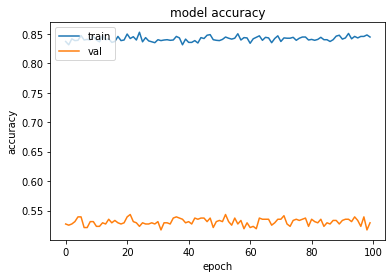

In [284]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()